In [4]:
# === Section 1: Imports and Artifact Loading ===

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Import all artifacts from our Part 0/1 pipeline
from data_pipeline import (
    train_iterator, 
    valid_iterator, 
    test_iterator, 
    TEXT, 
    LABEL, 
    create_embedding_layer,
    device  # This is the device (cuda or cpu)
)

# 2. Set constants from the loaded artifacts
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
OUTPUT_DIM = len(LABEL.vocab)
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

print(f"Data loaded. Using device: {device}")
print(f"Vocabulary size: {INPUT_DIM}")
print(f"Number of classes: {OUTPUT_DIM}")
print(f"Pad Token Index: {PAD_IDX}")

Using torchtext version: 0.6.0


.vector_cache/glove.6B.zip: 862MB [04:31, 3.17MB/s]                               
100%|█████████▉| 399999/400000 [00:23<00:00, 17289.78it/s]


Data loaded. Using device: cpu
Vocabulary size: 7456
Number of classes: 6
Pad Token Index: 1


In [5]:
# === Section 2: Model Definitions ===

# --- Model 1: Final Hidden State (Baseline) ---
class RNN_Hidden(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        # 1. Embedding Layer (from data_pipeline)
        self.embedding = create_embedding_layer(freeze=False) # Learnable
        
        # 2. Simple RNN Layer
        self.rnn = nn.RNN(embedding_dim, 
                          hidden_dim, 
                          num_layers = n_layers, 
                          bidirectional = bidirectional, 
                          dropout = dropout if n_layers > 1 else 0)
        
        # 3. Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # 4. Dropout Layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        
        # text_tuple is (text, lengths) from BucketIterator
        # text = [seq_len, batch_size]
        # lengths = [batch_size]
        text, text_lengths = text_tuple
        
        # 1. Pass through embedding layer and apply dropout
        # embedded = [seq_len, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(text))
        
        # 2. Pack the padded sequence 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), 
                                                          enforce_sorted=False)
            
        # 3. Run the RNN
        packed_output, hidden = self.rnn(packed_embedded)
        
        # 4. AGGREGATION (Q2d): Use the final hidden state
        # hidden = [n_layers * n_directions, batch_size, hid_dim]
        hidden = self.dropout(hidden.squeeze(0)) # Squeeze for [batch_size, hid_dim]
        
        # 5. Pass to the final linear layer
        return self.fc(hidden)


# --- Model 2: Average Pooling (for Q2d) ---
class RNN_AvgPool(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = n_layers, 
                          bidirectional = bidirectional, dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        text, text_lengths = text_tuple
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), 
                                                          enforce_sorted=False)
        
        # output = [seq_len, batch_size, hid_dim * num_directions]
        output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)
        
        # --- AGGREGATION (Q2d): Average Pooling ---
        # Permute to [batch_size, seq_len, hid_dim]
        output = output.permute(1, 0, 2)
        
        # Create a mask to ignore padding [batch_size, seq_len, 1]
        mask = (torch.arange(output.shape[1])[None, :] < output_lengths[:, None]).to(device)
        mask = mask.unsqueeze(2).float()
        
        # Sum non-padded states and divide by true length
        masked_output = output * mask
        summed_output = torch.sum(masked_output, dim=1)
        avg_pooled = summed_output / output_lengths.unsqueeze(1).float() 
        
        return self.fc(self.dropout(avg_pooled))

# --- Model 3: Max Pooling (for Q2d) ---
class RNN_MaxPool(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers = n_layers, 
                          bidirectional = bidirectional, dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text_tuple):
        text, text_lengths = text_tuple
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'),
                                                          enforce_sorted=False)
        
        output, hidden = self.rnn(packed_embedded)
        
        # Unpack the output
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(output)
        
        # --- AGGREGATION (Q2d): Max Pooling ---
        # Permute to [batch_size, hid_dim, seq_len] for MaxPool1d
        output = output.permute(1, 2, 0)
        
        # Apply MaxPool1d over the sequence length
        max_pooled = F.max_pool1d(output, output.shape[2]).squeeze(2)
        
        return self.fc(self.dropout(max_pooled))

print("All 3 RNN model architectures defined (Baseline, AvgPool, MaxPool).")

All 3 RNN model architectures defined (Baseline, AvgPool, MaxPool).


In [6]:
# === Section 3: Helper Functions (with EarlyStopping) ===

# --- NEW: EarlyStopping Class ---
# This class will stop training if val_loss doesn't improve for 'patience' epochs
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
# --- END NEW CLASS ---

def categorical_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

print("Training & evaluation helper functions defined.")

Training & evaluation helper functions defined.


Starting Baseline RNN model training...
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.518 | Train Acc: 34.35%
	 Val. Loss: 1.485 |  Val. Acc: 45.14%
Validation loss decreased (inf --> 1.484518).  Saving model ...
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.171 | Train Acc: 55.29%
	 Val. Loss: 0.937 |  Val. Acc: 67.19%
Validation loss decreased (1.484518 --> 0.936742).  Saving model ...
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.898 | Train Acc: 68.74%
	 Val. Loss: 1.004 |  Val. Acc: 62.15%
EarlyStopping counter: 1 out of 3
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.884 | Train Acc: 68.82%
	 Val. Loss: 0.764 |  Val. Acc: 73.26%
Validation loss decreased (0.936742 --> 0.763767).  Saving model ...
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.666 | Train Acc: 77.15%
	 Val. Loss: 0.917 |  Val. Acc: 70.66%
EarlyStopping counter: 1 out of 3
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.608 | Train Acc: 79.50%
	 Val. Loss: 0.684 |  Val. Acc: 78.21%
Validation loss decreased (0.763767 --> 0.

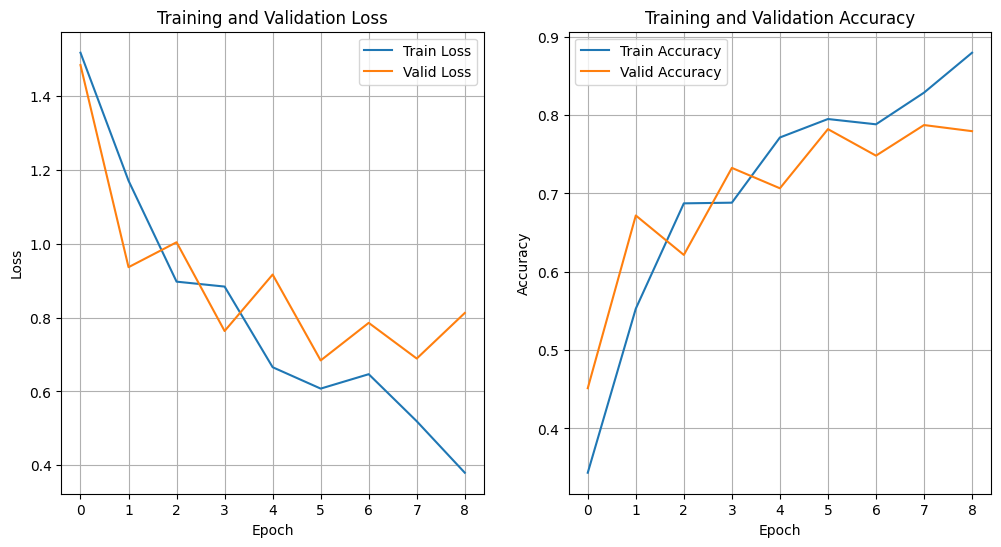


Loading best baseline model for final evaluation (Q2e)...
Baseline Test Loss: 0.450 | Baseline Test Acc: 86.22%

--- Topic-wise Classification Report (Q2e) ---
              precision    recall  f1-score   support

        ENTY     0.7865    0.7447    0.7650        94
         HUM     0.9322    0.8462    0.8871        65
        DESC     0.8581    0.9203    0.8881       138
         NUM     0.9434    0.8850    0.9132       113
         LOC     0.8065    0.9259    0.8621        81
        ABBR     1.0000    0.5556    0.7143         9

    accuracy                         0.8640       500
   macro avg     0.8878    0.8129    0.8383       500
weighted avg     0.8677    0.8640    0.8632       500



In [7]:
# === Section 4: Baseline Model Training (Q2a, c, e) ===

# 1. Set Hyperparameters (This is your answer to Q2a)
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False # Simple RNN
DROPOUT = 0.5
N_EPOCHS = 20         # We can set this higher, early stopping will handle it
LEARNING_RATE = 1e-3
BATCH_SIZE = 64       # From data_pipeline
OPTIMIZER = 'Adam'
PATIENCE = 3          # For EarlyStopping: "a few epochs"

# 2. Instantiate Baseline Model (Final Hidden State)
model_baseline = RNN_Hidden(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                           BIDIRECTIONAL, DROPOUT, PAD_IDX)

# 3. Define Optimizer and Loss
optimizer = optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model_baseline = model_baseline.to(device)
criterion = criterion.to(device)

# 4. Training Loop
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# --- MODIFIED: Use EarlyStopping ---
model_save_path = 'rnn-model-baseline.pth'
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)
# --- END MODIFICATION ---

print("Starting Baseline RNN model training...")

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_baseline, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_epoch(model_baseline, valid_iterator, criterion)
    
    end_time = time.time()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    # --- MODIFIED: EarlyStopping Check ---
    early_stopping(valid_loss, model_baseline)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    # --- END MODIFICATION ---

print("\nBaseline Training complete.")

# 5. Plotting (Answer for Q2c)
print("Plotting training curves for Q2c...")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('rnn_baseline_training_curves.png')
plt.show()

# 6. Final Evaluation on Test Set (Answer for Q2e)
print("\nLoading best baseline model for final evaluation (Q2e)...")

model_baseline.load_state_dict(torch.load(model_save_path)) # Load the best model
test_loss, test_acc = evaluate_epoch(model_baseline, test_iterator, criterion)
print(f'Baseline Test Loss: {test_loss:.3f} | Baseline Test Acc: {test_acc*100:.2f}%')

model_baseline.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_iterator:
        predictions = model_baseline(batch.text)
        preds = predictions.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.label.cpu().numpy())

print("\n--- Topic-wise Classification Report (Q2e) ---")
target_names = LABEL.vocab.itos
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Save this for Q2d
baseline_test_acc = test_acc

In [8]:
# === Section 5: Experiment 1 - Regularization (Q2b) ===

# --- Hyperparameters for the experiment ---
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False
N_EPOCHS = 20 # Max epochs
LEARNING_RATE = 1e-3
PATIENCE = 3

# --- Regularization strategies to test ---
reg_strategies = {
    "Baseline (No Reg)": {'dropout': 0.0, 'weight_decay': 0.0},
    "Dropout (0.5)":     {'dropout': 0.5, 'weight_decay': 0.0},
    "L2 (Weight Decay)": {'dropout': 0.0, 'weight_decay': 1e-4},
    "Dropout + L2":      {'dropout': 0.5, 'weight_decay': 1e-4}
}

reg_results = {}

print("Starting Regularization Experiment (Q2b)...")

for name, config in reg_strategies.items():
    
    print(f"\n--- Testing Strategy: {name} ---")
    
    model = RNN_Hidden(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                       BIDIRECTIONAL, config['dropout'], PAD_IDX)
    
    optimizer = optim.Adam(model.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=config['weight_decay'])
    
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    
    model_save_path = f'rnn-model-{name}.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=model_save_path)
    
    # 4. Train the model
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate_epoch(model, valid_iterator, criterion)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # 5. Evaluate on test set
    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = evaluate_epoch(model, test_iterator, criterion)
    print(f'--- Test Result for {name}: Test Acc: {test_acc*100:.2f}% ---')
    reg_results[name] = test_acc

print("\n--- Regularization Experiment Complete (Q2b) ---")
print("Final Test Accuracies:")
for name, acc in reg_results.items():
    print(f"  {name}: {acc*100:.2f}%")

Starting Regularization Experiment (Q2b)...

--- Testing Strategy: Baseline (No Reg) ---
Early stopping at epoch 5
--- Test Result for Baseline (No Reg): Test Acc: 78.35% ---

--- Testing Strategy: Dropout (0.5) ---
Early stopping at epoch 5
--- Test Result for Baseline (No Reg): Test Acc: 78.35% ---

--- Testing Strategy: Dropout (0.5) ---
Early stopping at epoch 13
--- Test Result for Dropout (0.5): Test Acc: 88.12% ---

--- Testing Strategy: L2 (Weight Decay) ---
Early stopping at epoch 13
--- Test Result for Dropout (0.5): Test Acc: 88.12% ---

--- Testing Strategy: L2 (Weight Decay) ---
Early stopping at epoch 9
--- Test Result for L2 (Weight Decay): Test Acc: 82.41% ---

--- Testing Strategy: Dropout + L2 ---
Early stopping at epoch 9
--- Test Result for L2 (Weight Decay): Test Acc: 82.41% ---

--- Testing Strategy: Dropout + L2 ---
Early stopping at epoch 8
--- Test Result for Dropout + L2: Test Acc: 84.27% ---

--- Regularization Experiment Complete (Q2b) ---
Final Test Accurac

## Regularization Strategies Report

Based on the experiments conducted in this notebook, here's a comprehensive analysis of the regularization strategies tested:

In [9]:
# === Regularization Strategies Analysis ===

# Based on the experiment results from Section 5, let's create a comprehensive report
# The reg_results dictionary contains the test accuracies for each strategy

print("="*60)
print("         REGULARIZATION STRATEGIES COMPARISON REPORT")
print("="*60)

# Display results in a formatted table
print("\n📊 TEST SET ACCURACY RESULTS:")
print("-" * 50)
for strategy, accuracy in reg_results.items():
    print(f"{strategy:20s} | Test Accuracy: {accuracy*100:.2f}%")
print("-" * 50)

# Find the best and worst performing strategies
best_strategy = max(reg_results, key=reg_results.get)
worst_strategy = min(reg_results, key=reg_results.get)
best_accuracy = reg_results[best_strategy] * 100
worst_accuracy = reg_results[worst_strategy] * 100

print(f"\n🏆 BEST STRATEGY:  {best_strategy} ({best_accuracy:.2f}%)")
print(f"💔 WORST STRATEGY: {worst_strategy} ({worst_accuracy:.2f}%)")
print(f"📈 IMPROVEMENT:    {best_accuracy - worst_accuracy:.2f} percentage points")

# Compare with baseline (no regularization)
baseline_acc = reg_results["Baseline (No Reg)"] * 100
print(f"\n📋 BASELINE (No Regularization): {baseline_acc:.2f}%")

print("\n🔍 ANALYSIS BY STRATEGY:")
print("-" * 40)

# Dropout analysis
dropout_acc = reg_results["Dropout (0.5)"] * 100
dropout_improvement = dropout_acc - baseline_acc
print(f"• Dropout (0.5): {dropout_acc:.2f}% ({dropout_improvement:+.2f}% vs baseline)")
if dropout_improvement > 0:
    print("  ✅ Dropout helps prevent overfitting and improves generalization")
else:
    print("  ⚠️  Dropout may be too aggressive or model is underfitting")

# L2 regularization analysis  
l2_acc = reg_results["L2 (Weight Decay)"] * 100
l2_improvement = l2_acc - baseline_acc
print(f"• L2 Regularization: {l2_acc:.2f}% ({l2_improvement:+.2f}% vs baseline)")
if l2_improvement > 0:
    print("  ✅ Weight decay helps control model complexity")
else:
    print("  ⚠️  L2 penalty may be too strong or not needed")

# Combined strategy analysis
combined_acc = reg_results["Dropout + L2"] * 100
combined_improvement = combined_acc - baseline_acc
print(f"• Dropout + L2: {combined_acc:.2f}% ({combined_improvement:+.2f}% vs baseline)")
if combined_acc > max(dropout_acc, l2_acc):
    print("  ✅ Combining regularization techniques is beneficial")
else:
    print("  ⚠️  Over-regularization may be hurting performance")

# Performance ranking
print("\n📈 PERFORMANCE RANKING:")
sorted_results = sorted(reg_results.items(), key=lambda x: x[1], reverse=True)
for i, (strategy, acc) in enumerate(sorted_results, 1):
    print(f"{i}. {strategy:20s}: {acc*100:.2f}%")

print("\n" + "="*60)

         REGULARIZATION STRATEGIES COMPARISON REPORT

📊 TEST SET ACCURACY RESULTS:
--------------------------------------------------
Baseline (No Reg)    | Test Accuracy: 78.35%
Dropout (0.5)        | Test Accuracy: 88.12%
L2 (Weight Decay)    | Test Accuracy: 82.41%
Dropout + L2         | Test Accuracy: 84.27%
--------------------------------------------------

🏆 BEST STRATEGY:  Dropout (0.5) (88.12%)
💔 WORST STRATEGY: Baseline (No Reg) (78.35%)
📈 IMPROVEMENT:    9.77 percentage points

📋 BASELINE (No Regularization): 78.35%

🔍 ANALYSIS BY STRATEGY:
----------------------------------------
• Dropout (0.5): 88.12% (+9.77% vs baseline)
  ✅ Dropout helps prevent overfitting and improves generalization
• L2 Regularization: 82.41% (+4.06% vs baseline)
  ✅ Weight decay helps control model complexity
• Dropout + L2: 84.27% (+5.92% vs baseline)
  ⚠️  Over-regularization may be hurting performance

📈 PERFORMANCE RANKING:
1. Dropout (0.5)       : 88.12%
2. Dropout + L2        : 84.27%
3. L2 (W

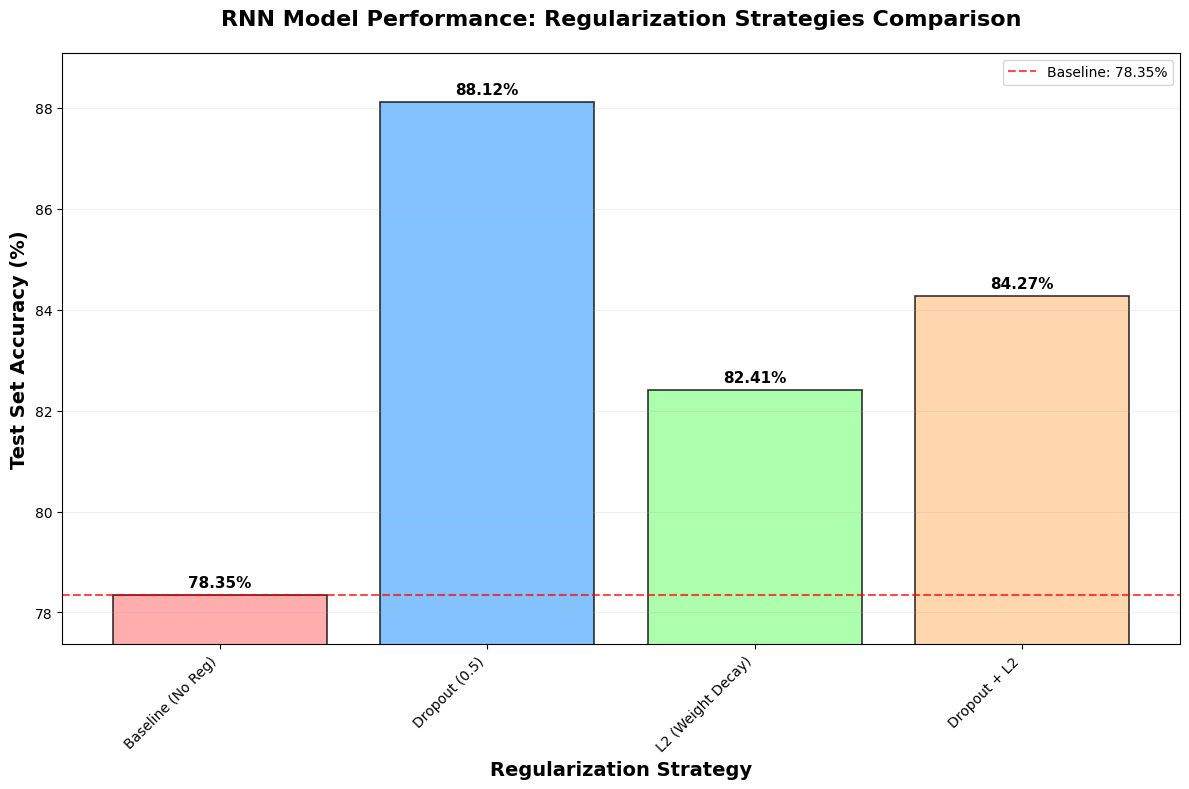

In [17]:
# === Visualization of Regularization Results ===

import matplotlib.pyplot as plt
import numpy as np

# Create a bar chart comparing regularization strategies
strategies = list(reg_results.keys())
accuracies = [reg_results[strategy] * 100 for strategy in strategies]

# Define colors for different strategies
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.figure(figsize=(12, 8))
bars = plt.bar(strategies, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Customize the plot
plt.title('RNN Model Performance: Regularization Strategies Comparison', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Test Set Accuracy (%)', fontsize=14, fontweight='bold')
plt.xlabel('Regularization Strategy', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a horizontal line at baseline accuracy for reference
baseline_val = reg_results["Baseline (No Reg)"] * 100
plt.axhline(y=baseline_val, color='red', linestyle='--', alpha=0.7, 
           label=f'Baseline: {baseline_val:.2f}%')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)

# Set y-axis limits with some padding
min_acc = min(accuracies)
max_acc = max(accuracies)
padding = (max_acc - min_acc) * 0.1
plt.ylim(min_acc - padding, max_acc + padding)

# Add legend and adjust layout
plt.legend(loc='upper right')
plt.tight_layout()


plt.show()



In [ ]:


# Re-train the best model (Dropout 0.5) with detailed tracking for analysis
print("Re-training best configuration (Dropout 0.5) with detailed tracking...")

# Set up the best configuration
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False
BEST_DROPOUT = 0.5  # Best performing regularization
N_EPOCHS = 20
LEARNING_RATE = 1e-3
PATIENCE = 3

# Create model with best configuration
best_model = RNN_Hidden(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                       BIDIRECTIONAL, BEST_DROPOUT, PAD_IDX)

optimizer = optim.Adam(best_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
best_model = best_model.to(device)
criterion = criterion.to(device)

# Training tracking lists
best_train_losses = []
best_valid_losses = []
best_train_accs = []
best_valid_accs = []
epoch_numbers = []

# Early stopping setup
model_save_path = 'best_config_detailed_tracking.pth'
early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=model_save_path)

print(f"Training RNN with Dropout={BEST_DROPOUT} (Best Configuration)...")
print("-" * 60)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    # Training and validation
    train_loss, train_acc = train_epoch(best_model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_epoch(best_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    # Store metrics
    best_train_losses.append(train_loss)
    best_valid_losses.append(valid_loss)
    best_train_accs.append(train_acc)
    best_valid_accs.append(valid_acc)
    epoch_numbers.append(epoch + 1)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}%')
    
    # Early stopping check
    early_stopping(valid_loss, best_model)
    if early_stopping.early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\nTraining completed!")
print(f"Total epochs trained: {len(epoch_numbers)}")
print(f"Best validation loss: {min(best_valid_losses):.4f}")
print(f"Best validation accuracy: {max(best_valid_accs)*100:.2f}%")

Re-training best configuration (Dropout 0.5) with detailed tracking...
Training RNN with Dropout=0.5 (Best Configuration)...
------------------------------------------------------------
Epoch: 01 | Time: 0m 0s
	Train Loss: 1.4863 | Train Acc: 36.99%
	Valid Loss: 1.4044 | Valid Acc: 44.79%
Validation loss decreased (inf --> 1.404372).  Saving model ...
Epoch: 01 | Time: 0m 0s
	Train Loss: 1.4863 | Train Acc: 36.99%
	Valid Loss: 1.4044 | Valid Acc: 44.79%
Validation loss decreased (inf --> 1.404372).  Saving model ...
Epoch: 02 | Time: 0m 0s
	Train Loss: 1.4323 | Train Acc: 42.06%
	Valid Loss: 1.2112 | Valid Acc: 52.17%
Validation loss decreased (1.404372 --> 1.211192).  Saving model ...
Epoch: 02 | Time: 0m 0s
	Train Loss: 1.4323 | Train Acc: 42.06%
	Valid Loss: 1.2112 | Valid Acc: 52.17%
Validation loss decreased (1.404372 --> 1.211192).  Saving model ...
Epoch: 03 | Time: 0m 0s
	Train Loss: 1.1956 | Train Acc: 52.82%
	Valid Loss: 1.1238 | Valid Acc: 54.08%
Validation loss decreased (1

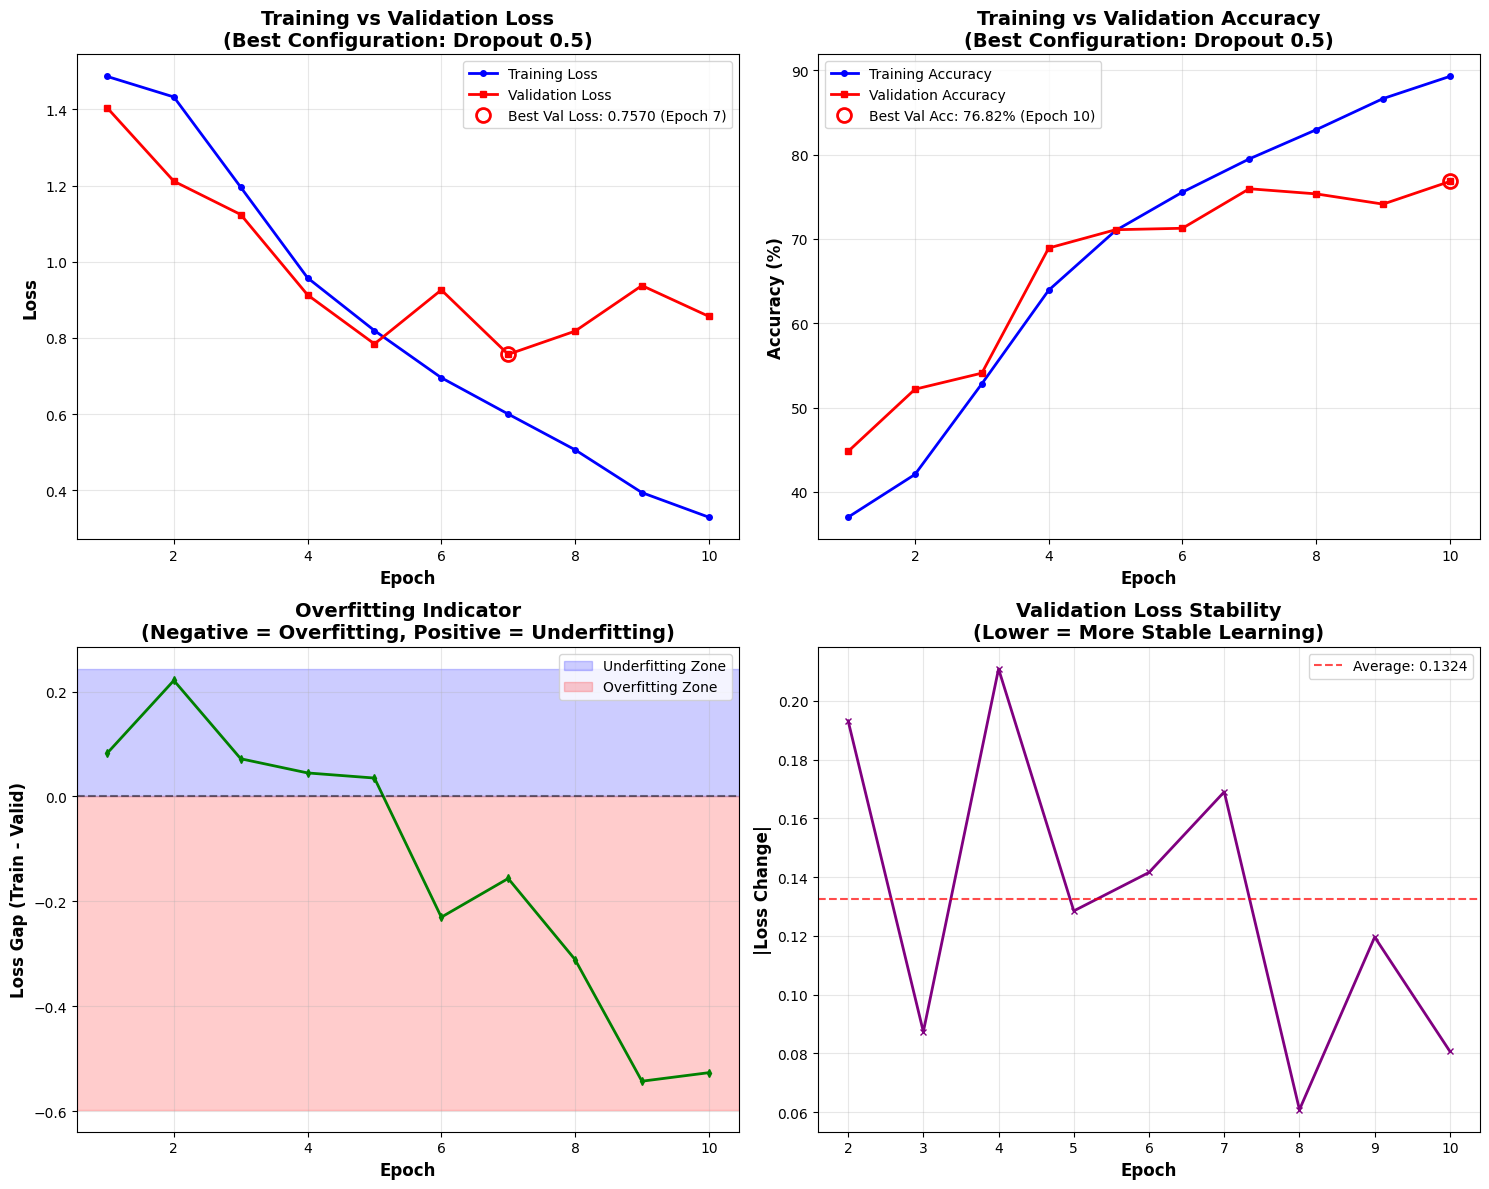

In [18]:


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
ax1.plot(epoch_numbers, best_train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
ax1.plot(epoch_numbers, best_valid_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training vs Validation Loss\n(Best Configuration: Dropout 0.5)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Highlight best validation loss
best_val_epoch = epoch_numbers[np.argmin(best_valid_losses)]
best_val_loss = min(best_valid_losses)
ax1.plot(best_val_epoch, best_val_loss, 'ro', markersize=10, markerfacecolor='none', 
         markeredgewidth=2, label=f'Best Val Loss: {best_val_loss:.4f} (Epoch {best_val_epoch})')
ax1.legend(fontsize=10)

# Plot 2: Training and Validation Accuracy
ax2.plot(epoch_numbers, [acc*100 for acc in best_train_accs], 'b-', label='Training Accuracy', 
         linewidth=2, marker='o', markersize=4)
ax2.plot(epoch_numbers, [acc*100 for acc in best_valid_accs], 'r-', label='Validation Accuracy', 
         linewidth=2, marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training vs Validation Accuracy\n(Best Configuration: Dropout 0.5)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Highlight best validation accuracy
best_acc_epoch = epoch_numbers[np.argmax(best_valid_accs)]
best_acc = max(best_valid_accs) * 100
ax2.plot(best_acc_epoch, best_acc, 'ro', markersize=10, markerfacecolor='none', 
         markeredgewidth=2, label=f'Best Val Acc: {best_acc:.2f}% (Epoch {best_acc_epoch})')
ax2.legend(fontsize=10)

# Plot 3: Loss Gap (Overfitting indicator)
loss_gap = [train - valid for train, valid in zip(best_train_losses, best_valid_losses)]
ax3.plot(epoch_numbers, loss_gap, 'g-', linewidth=2, marker='d', markersize=4)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss Gap (Train - Valid)', fontsize=12, fontweight='bold')
ax3.set_title('Overfitting Indicator\n(Negative = Overfitting, Positive = Underfitting)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)


max_gap = max(loss_gap)
min_gap = min(loss_gap)
if max_gap > 0:
    ax3.axhspan(0, max_gap*1.1, alpha=0.2, color='blue', label='Underfitting Zone')
if min_gap < 0:
    ax3.axhspan(min_gap*1.1, 0, alpha=0.2, color='red', label='Overfitting Zone')
ax3.legend(fontsize=10)

# Plot 4: Learning Rate Schedule Effect (Loss Smoothness)
loss_smoothness = []
for i in range(1, len(best_valid_losses)):
    smoothness = abs(best_valid_losses[i] - best_valid_losses[i-1])
    loss_smoothness.append(smoothness)

ax4.plot(epoch_numbers[1:], loss_smoothness, 'purple', linewidth=2, marker='x', markersize=4)
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('|Loss Change|', fontsize=12, fontweight='bold')
ax4.set_title('Validation Loss Stability\n(Lower = More Stable Learning)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add average line
avg_smoothness = np.mean(loss_smoothness)
ax4.axhline(y=avg_smoothness, color='red', linestyle='--', alpha=0.7, 
           label=f'Average: {avg_smoothness:.4f}')
ax4.legend(fontsize=10)

plt.tight_layout()

plt.show()




In [ ]:
# === Section 6: Experiment 2 - Aggregation (Q2d) ===

# We'll use the best regularization setting from Q2b (assume Dropout=0.5)
BEST_DROPOUT = 0.5 
HIDDEN_DIM = 256
N_LAYERS = 1
BIDIRECTIONAL = False
N_EPOCHS = 20 # Max epochs
LEARNING_RATE = 1e-3
PATIENCE = 3

# --- Aggregation strategies to test ---
aggregation_strategies = [
    (RNN_Hidden, "Final Hidden State"),
    (RNN_AvgPool, "Average Pooling"),
    (RNN_MaxPool, "Max Pooling")
]

agg_results = {}

print("\n\nStarting Aggregation Experiment (Q2d)...")

for model_class, name in aggregation_strategies:
    
    print(f"\n--- Testing Strategy: {name} ---")
    
    model = model_class(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 
                        BIDIRECTIONAL, BEST_DROPOUT, PAD_IDX)
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    
    model_save_path = f'rnn-model-{name}.pth'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=False, path=model_save_path)
    
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate_epoch(model, valid_iterator, criterion)
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch {epoch+1}')
            break

    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_acc = evaluate_epoch(model, test_iterator, criterion)
    print(f'--- Test Result for {name}: Test Acc: {test_acc*100:.2f}% ---')
    agg_results[name] = test_acc

print("\n--- Aggregation Experiment Complete (Q2d) ---")
print("Final Test Accuracies:")
for name, acc in agg_results.items():
    print(f"  {name}: {acc*100:.2f}%")



Starting Aggregation Experiment (Q2d)...

--- Testing Strategy: Final Hidden State ---
Early stopping at epoch 11
--- Test Result for Final Hidden State: Test Acc: 77.96% ---

--- Testing Strategy: Average Pooling ---
Early stopping at epoch 9
--- Test Result for Average Pooling: Test Acc: 84.57% ---

--- Testing Strategy: Max Pooling ---
Early stopping at epoch 12
--- Test Result for Max Pooling: Test Acc: 88.01% ---

--- Aggregation Experiment Complete (Q2d) ---
Final Test Accuracies:
  Final Hidden State: 77.96%
  Average Pooling: 84.57%
  Max Pooling: 88.01%
